# SG-FIGS: Synergy-Guided Oblique FIGS — Benchmark Demo

This notebook demonstrates the **SG-FIGS** (Synergy-Guided Oblique FIGS) method, which uses Partial Information Decomposition (PID) to discover synergistic feature interactions and guide oblique splits in the FIGS (Fast Interpretable Greedy-Tree Sums) framework.

**What this demo does:**
1. Loads a banknote authentication dataset (4 features, binary classification)
2. Computes pairwise synergy between features using PID (dit library)
3. Builds a synergy graph to identify feature subsets for oblique splits
4. Benchmarks three methods with 5-fold cross-validation:
   - **FIGS** (axis-aligned baseline via imodels)
   - **RO-FIGS** (random oblique splits)
   - **SG-FIGS** (synergy-guided oblique splits)
5. Compares accuracy, model complexity, and split interpretability

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# imodels — NOT on Colab, always install
_pip('imodels==2.0.4')

# dit dependencies (pypoman skipped — needs C lib pycddlib, not used by PID)
_pip('debtcollector', 'boltons', 'lattices>=0.3.5', 'PLTable')
_pip('--no-deps', 'dit==1.5')

# numpy, pandas, sklearn, scipy, matplotlib, networkx — pre-installed on Colab, install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scikit-learn==1.6.1', 'scipy==1.16.3',
         'matplotlib==3.10.0', 'networkx==3.6.1', 'tabulate==0.9.0')

# NumPy 2.0 compat shims — must be applied BEFORE importing dit
import numpy as np
if not hasattr(np, "alltrue"): np.alltrue = np.all
if not hasattr(np, "sometrue"): np.sometrue = np.any
if not hasattr(np, "product"): np.product = np.prod


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dit 1.5 requires pypoman, which is not installed.
mlxtend 0.24.0 requires matplotlib>=3.10.8, but you have matplotlib 3.10.0 which is incompatible.
mlxtend 0.24.0 requires numpy>=2.3.5, but you have numpy 2.0.2 which is incompatible.
mlxtend 0.24.0 requires pandas>=2.3.3, but you have pandas 2.2.2 which is incompatible.
mlxtend 0.24.0 requires scikit-learn>=1.8.0, but you have scikit-learn 1.6.1 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
import random
import time
import warnings
from collections import Counter
from pathlib import Path

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
from scipy.special import expit
from sklearn.linear_model import Ridge
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

print("All imports successful!")

All imports successful!


## Data Loading

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-b88b52-synergy-guided-oblique-splits-using-part/main/experiment_iter2_sg_figs_full_ex/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
ds_entry = data["datasets"][0]
print(f"Dataset: {ds_entry['dataset']}")
print(f"Examples: {len(ds_entry['examples'])}")
print(f"Sample keys: {list(ds_entry['examples'][0].keys())}")

Dataset: banknote
Examples: 60
Sample keys: ['input', 'output', 'metadata_fold', 'metadata_feature_names', 'metadata_task_type', 'metadata_n_classes', 'metadata_row_index', 'metadata_n_features', 'metadata_domain', 'predict_figs', 'predict_ro_figs', 'predict_sg_figs']


## Configuration

All tunable parameters are defined here. Values are set to produce meaningful results within the 5-minute runtime budget.

In [5]:
# --- Tunable parameters ---
# Original values from full experiment commented for reference

MAX_SPLITS_GRID = [5, 10]         # Original: [5, 10, 15, 25]
N_FOLDS = 5                       # Original: 5 (same — full!)
N_BINS = 5                        # Original: 5 (same)
THRESHOLD_PERCENTILE = 75         # Original: 75 (same)
NUM_REPETITIONS = 1               # Original: 5
SYNERGY_MAX_TIME = 60.0           # Original: 300.0
RANDOM_SEED = 42                  # Original: 42 (same)

## 1. Parse Dataset from JSON

Parse the loaded JSON into numpy arrays (X, y, feature_names, folds) for ML processing.

In [6]:
def load_dataset(dataset_dict: dict) -> dict:
    """Parse one dataset dict from JSON into X, y, feature_names, folds."""
    examples = dataset_dict["examples"]
    first_input = json.loads(examples[0]["input"])
    feature_names = list(first_input.keys())
    n_features = len(feature_names)

    X = np.zeros((len(examples), n_features), dtype=np.float64)
    y = np.zeros(len(examples), dtype=int)
    folds = np.zeros(len(examples), dtype=int)

    for i, ex in enumerate(examples):
        feat_dict = json.loads(ex["input"])
        X[i] = [feat_dict[fname] for fname in feature_names]
        y[i] = int(ex["output"])
        folds[i] = int(ex["metadata_fold"])

    return {
        "X": X,
        "y": y,
        "feature_names": feature_names,
        "folds": folds,
        "n_classes": int(examples[0]["metadata_n_classes"]),
        "n_features": n_features,
        "domain": examples[0].get("metadata_domain", "unknown"),
    }

ds = load_dataset(ds_entry)
print(f"Shape: X={ds['X'].shape}, y={ds['y'].shape}")
print(f"Features: {ds['feature_names']}")
print(f"Classes: {ds['n_classes']}, Class distribution: {Counter(ds['y'].tolist())}")
print(f"Folds: {Counter(ds['folds'].tolist())}")

Shape: X=(60, 4), y=(60,)
Features: ['V1', 'V2', 'V3', 'V4']
Classes: 2, Class distribution: Counter({0: 30, 1: 30})
Folds: Counter({0: 12, 1: 12, 2: 12, 3: 12, 4: 12})


## 2. PID Synergy Computation

Compute pairwise synergy between all feature pairs using Partial Information Decomposition (PID). Features are first discretized into quantile bins, then PID (BROJA or Williams-Beer) extracts the synergistic information each pair provides about the target.

In [7]:
def discretize_features(X: np.ndarray, n_bins: int = 5) -> tuple:
    """Discretize continuous features using quantile binning."""
    disc = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="quantile")
    X_disc = disc.fit_transform(X).astype(int)
    return X_disc, disc


def compute_pairwise_synergy(
    xi_disc: np.ndarray, xj_disc: np.ndarray, y_disc: np.ndarray
) -> float:
    """Compute PID synergy between features i, j w.r.t. target y."""
    import dit
    from dit.pid import PID_BROJA, PID_WB

    # Skip constant features
    if len(np.unique(xi_disc)) <= 1 or len(np.unique(xj_disc)) <= 1:
        return 0.0

    triples = list(
        zip(xi_disc.astype(int), xj_disc.astype(int), y_disc.astype(int))
    )
    counts = Counter(triples)
    total = len(triples)

    # Build dit distribution
    max_label = max(
        int(np.max(xi_disc)), int(np.max(xj_disc)), int(np.max(y_disc))
    )
    if max_label >= 10:
        outcomes = [f"{a} {b} {c}" for (a, b, c) in counts.keys()]
    else:
        outcomes = [f"{a}{b}{c}" for (a, b, c) in counts.keys()]
    pmf = [v / total for v in counts.values()]

    try:
        d = dit.Distribution(outcomes, pmf)
        n_joint_states = len(counts)
        if n_joint_states > 80:
            result = PID_WB(d)
        else:
            result = PID_BROJA(d)
        synergy = float(result[((0, 1),)])
    except Exception as e:
        synergy = 0.0

    return max(synergy, 0.0)


def build_synergy_matrix(
    X_disc: np.ndarray, y_disc: np.ndarray, max_time: float = 60.0
) -> np.ndarray:
    """Compute full pairwise synergy matrix S[i,j] with time budget."""
    d = X_disc.shape[1]
    S = np.zeros((d, d))
    total_pairs = d * (d - 1) // 2
    computed = 0
    t0 = time.time()

    # For high-dimensional datasets, pre-filter by mutual information
    if d > 20:
        from sklearn.feature_selection import mutual_info_classif
        mi_scores = mutual_info_classif(
            X_disc, y_disc, discrete_features=True, random_state=42
        )
        top_features = np.argsort(mi_scores)[-20:]
        pairs_to_compute = [
            (i, j)
            for idx_i, i in enumerate(sorted(top_features))
            for j in sorted(top_features)[idx_i + 1 :]
        ]
        total_pairs = len(pairs_to_compute)
    else:
        pairs_to_compute = [
            (i, j) for i in range(d) for j in range(i + 1, d)
        ]

    for i, j in pairs_to_compute:
        elapsed = time.time() - t0
        if elapsed > max_time:
            print(f"  Synergy hit time limit ({max_time:.0f}s) after {computed}/{total_pairs} pairs")
            break
        S[i, j] = compute_pairwise_synergy(X_disc[:, i], X_disc[:, j], y_disc)
        S[j, i] = S[i, j]
        computed += 1

    print(f"  Computed {computed}/{total_pairs} synergy pairs in {time.time()-t0:.1f}s")
    return S


def build_synergy_graph(
    S: np.ndarray, threshold_percentile: int = 75
) -> tuple:
    """Build networkx graph from synergy matrix."""
    import networkx as nx

    d = S.shape[0]
    upper_tri = S[np.triu_indices(d, k=1)]
    pos_values = upper_tri[upper_tri > 0]

    if len(pos_values) == 0:
        G = nx.Graph()
        G.add_nodes_from(range(d))
        return G, 0.0, []

    # Progressively lower threshold if graph is too sparse
    for pct in [threshold_percentile, 50, 25, 0]:
        tau = np.percentile(pos_values, pct) if pct > 0 else 0.0
        G = nx.Graph()
        G.add_nodes_from(range(d))
        for i in range(d):
            for j in range(i + 1, d):
                if S[i, j] > tau:
                    G.add_edge(i, j, weight=S[i, j])
        if G.number_of_edges() > 0:
            break

    # Extract candidate feature subsets
    subsets = []
    for clique in nx.find_cliques(G):
        if 2 <= len(clique) <= 5:
            subsets.append(sorted(clique))
    edge_subsets = [sorted([u, v]) for u, v in G.edges()]
    for es in edge_subsets:
        if es not in subsets:
            subsets.append(es)

    return G, tau, subsets


def compute_synergy_pipeline(
    X: np.ndarray,
    y: np.ndarray,
    n_bins: int = 5,
    threshold_percentile: int = 75,
) -> dict:
    """Full synergy pipeline: discretize -> synergy matrix -> graph -> subsets."""
    X_disc, disc = discretize_features(X, n_bins=n_bins)
    y_disc = y.astype(int)
    if y_disc.ndim > 1:
        y_disc = np.argmax(y_disc, axis=1)

    S = build_synergy_matrix(X_disc, y_disc, max_time=SYNERGY_MAX_TIME)
    G, tau, subsets = build_synergy_graph(S, threshold_percentile)

    return {
        "synergy_matrix": S,
        "graph": G,
        "threshold": tau,
        "subsets": subsets,
        "discretizer": disc,
    }

# Run synergy computation on training data (fold != 0)
train_mask = ds["folds"] != 0
t0 = time.time()
synergy_info = compute_synergy_pipeline(
    ds["X"][train_mask], ds["y"][train_mask],
    n_bins=N_BINS, threshold_percentile=THRESHOLD_PERCENTILE,
)
print(f"\nSynergy computation: {time.time()-t0:.1f}s")
print(f"  Graph: {synergy_info['graph'].number_of_nodes()} nodes, "
      f"{synergy_info['graph'].number_of_edges()} edges")
print(f"  Candidate subsets: {len(synergy_info['subsets'])}")
print(f"  Threshold: {synergy_info['threshold']:.6f}")
print(f"\nSynergy matrix:\n{synergy_info['synergy_matrix']}")

  Synergy hit time limit (60s) after 4/6 pairs
  Computed 4/6 synergy pairs in 81.8s

Synergy computation: 81.9s
  Graph: 4 nodes, 1 edges
  Candidate subsets: 1
  Threshold: 0.397115

Synergy matrix:
[[0.         0.4283647  0.38669803 0.31909172]
 [0.4283647  0.         0.32465991 0.        ]
 [0.38669803 0.32465991 0.         0.        ]
 [0.31909172 0.         0.         0.        ]]


## 3. Oblique FIGS Node and Split Primitives

Core data structure for tree nodes (supporting both axis-aligned and oblique splits) and the Ridge-based oblique split fitting routine.

In [8]:
class ObliqueFIGSNode:
    """Node supporting both axis-aligned and oblique splits."""

    def __init__(
        self, feature=None, features=None, weights=None, threshold=None,
        value=None, idxs=None, is_root=False, impurity=None,
        impurity_reduction=None, tree_num=None, left=None, right=None,
        left_temp=None, right_temp=None, depth=0, is_oblique=False, n_samples=0,
    ):
        self.feature = feature
        self.features = features
        self.weights = weights
        self.threshold = threshold
        self.value = value
        self.idxs = idxs
        self.is_root = is_root
        self.impurity = impurity
        self.impurity_reduction = impurity_reduction
        self.tree_num = tree_num
        self.left = left
        self.right = right
        self.left_temp = left_temp
        self.right_temp = right_temp
        self.depth = depth
        self.is_oblique = is_oblique
        self.n_samples = n_samples


def fit_oblique_split_ridge(
    X: np.ndarray, y_residuals: np.ndarray, feature_indices: list,
) -> dict | None:
    """Fit oblique split using Ridge regression + 1D stump."""
    X_sub = X[:, feature_indices]
    if X_sub.shape[0] < 5:
        return None

    col_std = np.std(X_sub, axis=0)
    non_const = col_std > 1e-12
    if not np.any(non_const):
        return None

    ridge = Ridge(alpha=1.0)
    ridge.fit(X_sub, y_residuals)
    weights = ridge.coef_.flatten()
    projections = X_sub @ weights

    if np.std(projections) < 1e-12:
        return None

    stump = DecisionTreeRegressor(max_depth=1, min_samples_leaf=2)
    stump.fit(projections.reshape(-1, 1), y_residuals)

    tree = stump.tree_
    if tree.feature[0] == -2 or tree.n_node_samples.shape[0] < 3:
        return None

    threshold = tree.threshold[0]
    impurity = tree.impurity
    n_node_samples = tree.n_node_samples

    impurity_reduction = (
        n_node_samples[0] * impurity[0]
        - n_node_samples[1] * impurity[1]
        - n_node_samples[2] * impurity[2]
    ) / max(n_node_samples[0], 1)

    left_mask = projections <= threshold
    if np.sum(left_mask) < 1 or np.sum(~left_mask) < 1:
        return None

    return {
        "features": np.array(feature_indices),
        "weights": weights,
        "threshold": threshold,
        "impurity_reduction": impurity_reduction,
        "left_mask": left_mask,
        "value_left": np.mean(y_residuals[left_mask]),
        "value_right": np.mean(y_residuals[~left_mask]),
        "n_left": int(np.sum(left_mask)),
        "n_right": int(np.sum(~left_mask)),
    }

print("Node and split primitives defined.")

Node and split primitives defined.


## 4. BaseFIGSOblique — FIGS Greedy Loop with Oblique Support

The core FIGS algorithm: maintains a list of leaf nodes, greedily picks the best split (oblique or axis-aligned), and expands the tree-sum. Subclasses (`ROFIGSClassifier`, `SGFIGSClassifier`) differ only in how they select feature subsets for oblique splits.

In [9]:
class BaseFIGSOblique:
    """FIGS greedy-tree-sum with oblique split support."""

    def __init__(
        self, max_splits: int = 25, max_trees: int | None = None,
        max_depth: int | None = None, min_impurity_decrease: float = 0.0,
        num_repetitions: int = 5, beam_size: int | None = None,
        random_state: int | None = None,
    ):
        self.max_splits = max_splits
        self.max_trees = max_trees
        self.max_depth = max_depth if max_depth else 6
        self.min_impurity_decrease = min_impurity_decrease
        self.num_repetitions = num_repetitions
        self.beam_size = beam_size
        self.random_state = random_state
        self.trees_ = []
        self.complexity_ = 0

    def _precompute(self, X, y):
        pass

    def _get_feature_subsets_for_split(self, X, rng):
        raise NotImplementedError

    @staticmethod
    def _weighted_mse(y):
        if len(y) == 0:
            return 0.0
        return float(np.var(y) * len(y))

    def _best_split_for_node(self, X, residuals, idxs, rng):
        idx_arr = np.where(idxs)[0]
        if len(idx_arr) < 5:
            return None

        X_node = X[idx_arr]
        y_node = residuals[idx_arr]
        parent_mse = self._weighted_mse(y_node)

        best = None
        best_gain = self.min_impurity_decrease

        # Axis-aligned stump
        stump = DecisionTreeRegressor(max_depth=1, min_samples_leaf=2)
        stump.fit(X_node, y_node)
        t = stump.tree_
        if t.feature[0] >= 0 and t.n_node_samples.shape[0] >= 3:
            left_sub = X_node[:, t.feature[0]] <= t.threshold[0]
            if 2 <= np.sum(left_sub) <= len(idx_arr) - 2:
                gain = parent_mse - (
                    self._weighted_mse(y_node[left_sub])
                    + self._weighted_mse(y_node[~left_sub])
                )
                if gain > best_gain:
                    best_gain = gain
                    full_left = np.zeros(len(X), dtype=bool)
                    full_left[idx_arr[left_sub]] = True
                    best = {
                        "is_oblique": False, "feature": int(t.feature[0]),
                        "threshold": float(t.threshold[0]), "gain": gain,
                        "left_mask": full_left,
                        "val_left": float(np.mean(y_node[left_sub])),
                        "val_right": float(np.mean(y_node[~left_sub])),
                        "n_left": int(np.sum(left_sub)),
                        "n_right": int(np.sum(~left_sub)),
                    }

        # Oblique splits
        for _ in range(self.num_repetitions):
            subsets = self._get_feature_subsets_for_split(X, rng)
            for feat_idx in subsets:
                if len(feat_idx) < 2:
                    continue
                obl = fit_oblique_split_ridge(X_node, y_node, feat_idx)
                if obl is None:
                    continue
                sub_left = obl["left_mask"]
                if np.sum(sub_left) < 2 or np.sum(~sub_left) < 2:
                    continue
                gain = parent_mse - (
                    self._weighted_mse(y_node[sub_left])
                    + self._weighted_mse(y_node[~sub_left])
                )
                if gain > best_gain:
                    best_gain = gain
                    full_left = np.zeros(len(X), dtype=bool)
                    full_left[idx_arr[sub_left]] = True
                    best = {
                        "is_oblique": True, "features": obl["features"],
                        "weights": obl["weights"], "threshold": obl["threshold"],
                        "gain": gain, "left_mask": full_left,
                        "val_left": float(np.mean(y_node[sub_left])),
                        "val_right": float(np.mean(y_node[~sub_left])),
                        "n_left": int(np.sum(sub_left)),
                        "n_right": int(np.sum(~sub_left)),
                    }
        return best

    def fit(self, X, y, feature_names=None):
        rng = random.Random(self.random_state)
        np.random.seed(self.random_state if self.random_state else 42)
        n_samples, n_features = X.shape
        self.n_features_ = n_features
        self.feature_names_ = feature_names

        self.scaler_ = MinMaxScaler()
        X_s = self.scaler_.fit_transform(X)
        self._precompute(X_s, y)

        if self.beam_size is None:
            self.beam_size = max(2, n_features // 2)

        y_target = y.astype(float)
        all_idxs = np.ones(n_samples, dtype=bool)
        root_leaf = ObliqueFIGSNode(
            value=float(np.mean(y_target)), idxs=all_idxs, is_root=True,
            tree_num=0, depth=0, n_samples=n_samples,
        )
        self.trees_ = [root_leaf]
        leaves = [(0, root_leaf, None, None)]
        total_splits = 0

        while total_splits < self.max_splits and leaves:
            predictions = self._compute_predictions(X_s)
            residuals = y_target - predictions

            scored = []
            for tree_idx, leaf, parent, side in leaves:
                if leaf.depth >= self.max_depth:
                    continue
                split_info = self._best_split_for_node(X_s, residuals, leaf.idxs, rng)
                if split_info is not None:
                    scored.append((split_info["gain"], tree_idx, leaf, parent, side, split_info))

            if not scored:
                if self.max_trees is None or len(self.trees_) < self.max_trees:
                    new_tree_idx = len(self.trees_)
                    new_root = ObliqueFIGSNode(
                        value=float(np.mean(residuals)), idxs=all_idxs,
                        is_root=True, tree_num=new_tree_idx, depth=0, n_samples=n_samples,
                    )
                    self.trees_.append(new_root)
                    leaves.append((new_tree_idx, new_root, None, None))
                    continue
                else:
                    break

            scored.sort(key=lambda x: x[0], reverse=True)
            best_gain, tree_idx, leaf, parent, side, info = scored[0]

            node = ObliqueFIGSNode(
                idxs=leaf.idxs, is_root=leaf.is_root, tree_num=tree_idx,
                depth=leaf.depth, impurity_reduction=best_gain,
                is_oblique=info["is_oblique"], n_samples=leaf.n_samples,
            )
            if info["is_oblique"]:
                node.features = info["features"]
                node.weights = info["weights"]
            else:
                node.feature = info["feature"]
            node.threshold = info["threshold"]

            left_idxs = info["left_mask"]
            right_idxs = leaf.idxs & ~left_idxs

            left_leaf = ObliqueFIGSNode(
                value=info["val_left"], idxs=left_idxs, tree_num=tree_idx,
                depth=leaf.depth + 1, n_samples=info["n_left"],
            )
            right_leaf = ObliqueFIGSNode(
                value=info["val_right"], idxs=right_idxs, tree_num=tree_idx,
                depth=leaf.depth + 1, n_samples=info["n_right"],
            )
            node.left = left_leaf
            node.right = right_leaf

            if parent is None:
                self.trees_[tree_idx] = node
            else:
                if side == "left":
                    parent.left = node
                else:
                    parent.right = node

            leaves = [(ti, lf, p, s) for (ti, lf, p, s) in leaves if lf is not leaf]
            leaves.append((tree_idx, left_leaf, node, "left"))
            leaves.append((tree_idx, right_leaf, node, "right"))
            total_splits += 1

        # Final leaf value update
        for t_idx, tree in enumerate(self.trees_):
            other_preds = np.zeros(n_samples)
            for j, other_tree in enumerate(self.trees_):
                if j != t_idx:
                    other_preds += self._predict_tree(other_tree, X_s)
            residuals_for_tree = y_target - other_preds
            self._update_leaf_values(tree, residuals_for_tree)

        self.complexity_ = total_splits
        return self

    def _update_leaf_values(self, node, residuals):
        if node is None:
            return
        if node.left is None and node.right is None:
            if node.idxs is not None and np.any(node.idxs):
                node.value = float(np.mean(residuals[node.idxs]))
            return
        self._update_leaf_values(node.left, residuals)
        self._update_leaf_values(node.right, residuals)

    def _compute_predictions(self, X):
        preds = np.zeros(X.shape[0])
        for tree in self.trees_:
            preds += self._predict_tree(tree, X)
        return preds

    def _predict_tree(self, root, X):
        preds = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            preds[i] = self._predict_single(root, X[i])
        return preds

    def _predict_single(self, node, x):
        if node is None:
            return 0.0
        if node.left is None and node.right is None:
            v = node.value
            return float(v) if v is not None else 0.0
        if node.is_oblique and node.features is not None and node.weights is not None:
            go_left = np.dot(x[node.features], node.weights) <= node.threshold
        elif node.feature is not None:
            go_left = x[node.feature] <= node.threshold
        else:
            return float(node.value) if node.value is not None else 0.0
        return self._predict_single(node.left if go_left else node.right, x)

    def predict(self, X):
        X_scaled = self.scaler_.transform(X)
        preds = np.zeros(X_scaled.shape[0])
        for tree in self.trees_:
            preds += self._predict_tree(tree, X_scaled)
        return (preds > 0.5).astype(int)

    def predict_proba(self, X):
        X_scaled = self.scaler_.transform(X)
        preds = np.zeros(X_scaled.shape[0])
        for tree in self.trees_:
            preds += self._predict_tree(tree, X_scaled)
        probs = np.clip(preds, 0.0, 1.0)
        return np.vstack((1 - probs, probs)).T

print("BaseFIGSOblique defined.")

BaseFIGSOblique defined.


## 5. Method Variants: RO-FIGS, SG-FIGS, and FIGS Baseline

- **ROFIGSClassifier**: Random oblique splits (random feature subsets)
- **SGFIGSClassifier**: Synergy-guided oblique splits (uses PID synergy subsets)
- **FIGSBaselineWrapper**: Standard axis-aligned FIGS from imodels library

In [10]:
class ROFIGSClassifier(BaseFIGSOblique):
    """RO-FIGS baseline: random feature subsets for oblique splits."""

    def _precompute(self, X, y):
        pass

    def _get_feature_subsets_for_split(self, X, rng):
        d = X.shape[1]
        beam = self.beam_size if self.beam_size else max(2, d // 2)
        indices = list(range(d))
        subset = rng.sample(indices, min(beam, d))
        return [subset]


class SGFIGSClassifier(BaseFIGSOblique):
    """SG-FIGS: synergy-guided feature subsets for oblique splits."""

    def __init__(self, n_bins=5, threshold_percentile=75,
                 precomputed_synergy=None, **kwargs):
        super().__init__(**kwargs)
        self.n_bins = n_bins
        self.threshold_percentile = threshold_percentile
        self.synergy_info_ = precomputed_synergy

    def _precompute(self, X, y):
        if self.synergy_info_ is not None:
            return
        self.synergy_info_ = compute_synergy_pipeline(
            X, y, n_bins=self.n_bins,
            threshold_percentile=self.threshold_percentile,
        )

    def _get_feature_subsets_for_split(self, X, rng):
        subsets = self.synergy_info_["subsets"] if self.synergy_info_ else []
        d = X.shape[1]
        beam = self.beam_size if self.beam_size else max(2, d // 2)

        if not subsets:
            indices = list(range(d))
            return [rng.sample(indices, min(beam, d))]

        chosen = list(rng.choice(subsets))

        if len(chosen) < beam:
            remaining = [f for f in range(d) if f not in chosen]
            pad_count = min(beam - len(chosen), len(remaining))
            if pad_count > 0:
                pad = rng.sample(remaining, pad_count)
                chosen = chosen + pad
        elif len(chosen) > beam:
            S = self.synergy_info_["synergy_matrix"]
            scored = [(f, sum(S[f, g] for g in chosen if g != f)) for f in chosen]
            scored.sort(key=lambda x: x[1], reverse=True)
            chosen = [f for f, _ in scored[:beam]]

        return [sorted(chosen)]


class FIGSBaselineWrapper:
    """Wrapper around imodels FIGSClassifier for consistent API."""

    def __init__(self, max_splits=25):
        from imodels import FIGSClassifier
        self.model = FIGSClassifier(max_rules=max_splits)
        self.max_splits = max_splits
        self.trees_ = []
        self.complexity_ = 0

    def fit(self, X, y, feature_names=None):
        self.model.fit(X, y, feature_names=feature_names)
        self.trees_ = self.model.trees_ if hasattr(self.model, "trees_") else []
        self.complexity_ = self.model.complexity_ if hasattr(self.model, "complexity_") else 0
        return self

    def predict(self, X):
        return self.model.predict(X).astype(int)

    def predict_proba(self, X):
        return self.model.predict_proba(X)


print("All three method variants defined: FIGS, RO-FIGS, SG-FIGS")

All three method variants defined: FIGS, RO-FIGS, SG-FIGS


## 6. Evaluation Metrics

Helper functions to measure model complexity and split interpretability (fraction of oblique splits using high-synergy feature pairs).

In [11]:
def collect_oblique_nodes(node, result):
    """Recursively collect oblique internal nodes."""
    if node is None:
        return
    if node.is_oblique and (node.left is not None or node.right is not None):
        result.append(node)
    collect_oblique_nodes(node.left, result)
    collect_oblique_nodes(node.right, result)


def compute_avg_features_per_split(model) -> float:
    if not hasattr(model, "trees_"):
        return 1.0
    oblique_nodes = []
    for tree_root in model.trees_:
        collect_oblique_nodes(tree_root, oblique_nodes)
    if not oblique_nodes:
        return 1.0
    counts = []
    for node in oblique_nodes:
        if node.features is not None:
            n_nonzero = int(np.sum(np.abs(node.weights) > 1e-10)) if node.weights is not None else len(node.features)
            counts.append(n_nonzero)
        else:
            counts.append(1)
    return float(np.mean(counts)) if counts else 1.0


def compute_split_interpretability_score(model, synergy_matrix) -> float:
    """Fraction of oblique splits whose features have above-median synergy."""
    d = synergy_matrix.shape[0]
    all_synergies = synergy_matrix[np.triu_indices(d, k=1)]
    pos_syn = all_synergies[all_synergies > 0]
    median_synergy = float(np.median(pos_syn)) if len(pos_syn) > 0 else 0.0

    oblique_splits = []
    if hasattr(model, "trees_"):
        for tree_root in model.trees_:
            collect_oblique_nodes(tree_root, oblique_splits)

    if not oblique_splits:
        return 0.0

    above_median_count = 0
    for node in oblique_splits:
        feats = node.features
        if feats is None or len(feats) < 2:
            continue
        pair_synergies = []
        for i_idx in range(len(feats)):
            for j_idx in range(i_idx + 1, len(feats)):
                fi, fj = int(feats[i_idx]), int(feats[j_idx])
                if fi < d and fj < d:
                    pair_synergies.append(synergy_matrix[fi, fj])
        if pair_synergies and np.mean(pair_synergies) > median_synergy:
            above_median_count += 1

    return above_median_count / len(oblique_splits)


def count_total_nodes(node) -> int:
    if node is None:
        return 0
    if node.left is None and node.right is None:
        return 0
    return 1 + count_total_nodes(node.left) + count_total_nodes(node.right)


def count_trees_and_splits(model):
    if hasattr(model, "trees_"):
        n_trees = len(model.trees_)
        n_splits = sum(count_total_nodes(t) for t in model.trees_)
    elif hasattr(model, "model") and hasattr(model.model, "trees_"):
        n_trees = len(model.model.trees_)
        n_splits = model.model.complexity_ if hasattr(model.model, "complexity_") else 0
    else:
        n_trees = 0
        n_splits = 0
    return n_trees, n_splits


print("Evaluation metrics defined.")

Evaluation metrics defined.


## 7. Run Benchmark — Train and Evaluate All Three Methods

For each method (FIGS, RO-FIGS, SG-FIGS), perform hyperparameter tuning over `max_splits` then evaluate on held-out folds.

In [12]:
def create_model(method_name, max_splits, beam_size, precomputed_synergy=None):
    """Create a model by method name."""
    if method_name == "FIGS":
        return FIGSBaselineWrapper(max_splits=max_splits)
    elif method_name == "RO-FIGS":
        return ROFIGSClassifier(
            max_splits=max_splits, beam_size=beam_size,
            random_state=RANDOM_SEED, num_repetitions=NUM_REPETITIONS,
        )
    elif method_name == "SG-FIGS":
        return SGFIGSClassifier(
            max_splits=max_splits, beam_size=beam_size,
            random_state=RANDOM_SEED, num_repetitions=NUM_REPETITIONS,
            n_bins=N_BINS, threshold_percentile=THRESHOLD_PERCENTILE,
            precomputed_synergy=precomputed_synergy,
        )
    else:
        raise ValueError(f"Unknown method: {method_name}")


X, y = ds["X"], ds["y"]
folds = ds["folds"]
feature_names = ds["feature_names"]
beam_size = max(2, X.shape[1] // 2)

results = {}
total_start = time.time()

for method_name in ["FIGS", "RO-FIGS", "SG-FIGS"]:
    print(f"\n{'='*50}")
    print(f"Evaluating: {method_name}")
    print(f"{'='*50}")
    method_start = time.time()

    # Hyperparameter tuning on fold 0
    best_config = None
    best_val_score = -1.0

    for max_splits in MAX_SPLITS_GRID:
        try:
            train_idx = folds != 0
            val_idx = folds == 0
            if np.sum(train_idx) < 5 or np.sum(val_idx) < 2:
                continue
            model = create_model(method_name, max_splits=max_splits,
                                 beam_size=beam_size, precomputed_synergy=synergy_info)
            model.fit(X[train_idx], y[train_idx], feature_names=feature_names)
            y_pred = model.predict(X[val_idx])
            val_score = balanced_accuracy_score(y[val_idx], y_pred)
            if val_score > best_val_score:
                best_val_score = val_score
                best_config = max_splits
        except Exception as e:
            print(f"  max_splits={max_splits} failed: {e}")
            continue

    if best_config is None:
        best_config = 5
    print(f"  Best max_splits={best_config} (val_acc={best_val_score:.4f})")

    # Evaluate on all folds
    fold_results = []
    unique_folds = sorted(set(folds))[:N_FOLDS]

    for fold_id in unique_folds:
        try:
            test_idx = folds == fold_id
            train_idx = ~test_idx
            if np.sum(train_idx) < 5 or np.sum(test_idx) < 2:
                continue

            model = create_model(method_name, max_splits=best_config,
                                 beam_size=beam_size, precomputed_synergy=synergy_info)
            model.fit(X[train_idx], y[train_idx], feature_names=feature_names)
            y_pred = model.predict(X[test_idx])
            bal_acc = balanced_accuracy_score(y[test_idx], y_pred)

            auc = None
            try:
                y_proba = model.predict_proba(X[test_idx])
                if y_proba.shape[1] == 2:
                    auc = roc_auc_score(y[test_idx], y_proba[:, 1])
            except Exception:
                pass

            n_trees, n_splits = count_trees_and_splits(model)
            avg_feat = compute_avg_features_per_split(model) if method_name != "FIGS" else 1.0

            interp_score = None
            if method_name != "FIGS" and synergy_info is not None:
                try:
                    interp_score = compute_split_interpretability_score(
                        model, synergy_info["synergy_matrix"]
                    )
                except Exception:
                    pass

            fold_results.append({
                "fold": fold_id,
                "balanced_accuracy": round(bal_acc, 4),
                "auc": round(auc, 4) if auc is not None else None,
                "n_splits": n_splits,
                "n_trees": n_trees,
                "avg_features_per_split": round(avg_feat, 4),
                "split_interpretability_score": round(interp_score, 4) if interp_score is not None else None,
            })
            auc_str = f"{auc:.4f}" if auc is not None else "N/A"
            print(f"  Fold {fold_id}: acc={bal_acc:.4f}, auc={auc_str}, splits={n_splits}")
        except Exception as e:
            print(f"  Fold {fold_id} failed: {e}")
            continue

    if fold_results:
        accs = [r["balanced_accuracy"] for r in fold_results]
        aucs = [r["auc"] for r in fold_results if r["auc"] is not None]
        splits = [r["n_splits"] for r in fold_results]
        interps = [r["split_interpretability_score"] for r in fold_results if r["split_interpretability_score"] is not None]

        results[method_name] = {
            "best_max_splits": best_config,
            "fold_results": fold_results,
            "mean_balanced_accuracy": round(float(np.mean(accs)), 4),
            "std_balanced_accuracy": round(float(np.std(accs)), 4),
            "mean_auc": round(float(np.mean(aucs)), 4) if aucs else None,
            "mean_n_splits": round(float(np.mean(splits)), 2),
            "mean_split_interpretability": round(float(np.mean(interps)), 4) if interps else None,
        }
        method_time = time.time() - method_start
        print(f"\n  {method_name} SUMMARY: acc={results[method_name]['mean_balanced_accuracy']:.4f} "
              f"±{results[method_name]['std_balanced_accuracy']:.4f}, "
              f"splits={results[method_name]['mean_n_splits']:.1f}, time={method_time:.1f}s")

total_time = time.time() - total_start
print(f"\n{'='*50}")
print(f"Total benchmark time: {total_time:.1f}s")


Evaluating: FIGS


  Best max_splits=5 (val_acc=0.6857)
  Fold 0: acc=0.6857, auc=0.6857, splits=4
  Fold 1: acc=0.9286, auc=0.9286, splits=5
  Fold 2: acc=0.8125, auc=0.8125, splits=5
  Fold 3: acc=1.0000, auc=1.0000, splits=5
  Fold 4: acc=0.8125, auc=0.8125, splits=5

  FIGS SUMMARY: acc=0.8479 ±0.1081, splits=4.8, time=0.6s

Evaluating: RO-FIGS


  Best max_splits=5 (val_acc=0.7571)
  Fold 0: acc=0.7571, auc=0.6857, splits=5
  Fold 1: acc=1.0000, auc=1.0000, splits=5
  Fold 2: acc=0.6875, auc=0.9062, splits=5


  Fold 3: acc=0.9375, auc=1.0000, splits=5
  Fold 4: acc=0.6250, auc=0.8281, splits=5

  RO-FIGS SUMMARY: acc=0.8014 ±0.1442, splits=5.0, time=0.6s

Evaluating: SG-FIGS
  Best max_splits=5 (val_acc=0.7571)
  Fold 0: acc=0.7571, auc=0.7571, splits=5


  Fold 1: acc=1.0000, auc=1.0000, splits=5
  Fold 2: acc=0.8125, auc=0.7969, splits=5
  Fold 3: acc=0.9375, auc=0.9375, splits=5
  Fold 4: acc=0.8750, auc=0.9062, splits=5

  SG-FIGS SUMMARY: acc=0.8764 ±0.0864, splits=5.0, time=0.3s

Total benchmark time: 1.5s


## 8. Results Visualization

Summary table and bar chart comparing the three methods on accuracy, AUC, model complexity, and split interpretability.

RESULTS SUMMARY — Banknote Authentication Dataset
Method         Accuracy        AUC   Splits   Interp
--------------------------------------------------
FIGS             0.8479     0.8479      4.8      N/A
RO-FIGS          0.8014     0.8840      5.0   0.8333
SG-FIGS          0.8764     0.8795      5.0   0.6000
--------------------------------------------------


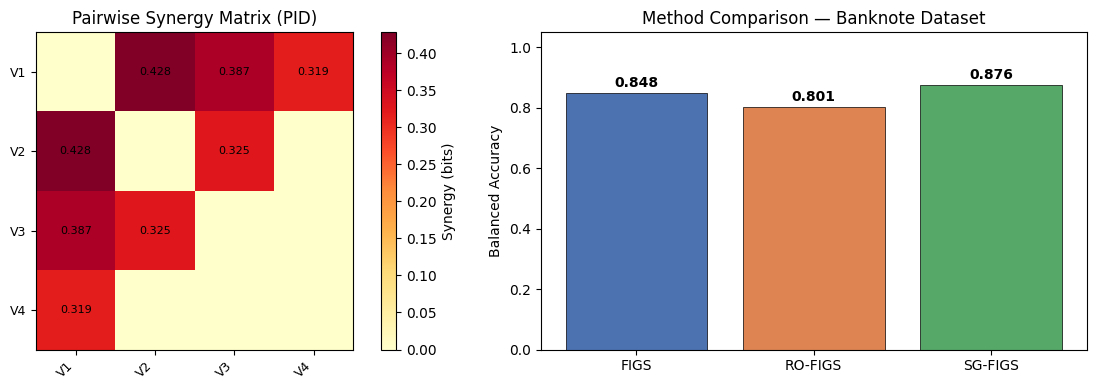


Demo complete!


In [13]:
# --- Results Summary Table ---
print("=" * 60)
print("RESULTS SUMMARY — Banknote Authentication Dataset")
print("=" * 60)
print(f"{'Method':<12} {'Accuracy':>10} {'AUC':>10} {'Splits':>8} {'Interp':>8}")
print("-" * 50)

for method_name in ["FIGS", "RO-FIGS", "SG-FIGS"]:
    if method_name in results:
        r = results[method_name]
        acc = f"{r['mean_balanced_accuracy']:.4f}"
        auc = f"{r['mean_auc']:.4f}" if r.get('mean_auc') else "N/A"
        splits = f"{r['mean_n_splits']:.1f}"
        interp = f"{r['mean_split_interpretability']:.4f}" if r.get('mean_split_interpretability') is not None else "N/A"
        print(f"{method_name:<12} {acc:>10} {auc:>10} {splits:>8} {interp:>8}")

print("-" * 50)

# --- Synergy Heatmap ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Synergy matrix heatmap
S = synergy_info["synergy_matrix"]
im = axes[0].imshow(S, cmap="YlOrRd", interpolation="nearest")
axes[0].set_xticks(range(len(feature_names)))
axes[0].set_yticks(range(len(feature_names)))
axes[0].set_xticklabels(feature_names, rotation=45, ha="right", fontsize=9)
axes[0].set_yticklabels(feature_names, fontsize=9)
axes[0].set_title("Pairwise Synergy Matrix (PID)")
plt.colorbar(im, ax=axes[0], label="Synergy (bits)")

# Add values in cells
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        if S[i, j] > 0:
            axes[0].text(j, i, f"{S[i,j]:.3f}", ha="center", va="center", fontsize=8)

# Right: Bar chart of accuracy comparison
methods = [m for m in ["FIGS", "RO-FIGS", "SG-FIGS"] if m in results]
accs = [results[m]["mean_balanced_accuracy"] for m in methods]
colors = ["#4C72B0", "#DD8452", "#55A868"][:len(methods)]
bars = axes[1].bar(methods, accs, color=colors, edgecolor="black", linewidth=0.5)
axes[1].set_ylabel("Balanced Accuracy")
axes[1].set_title("Method Comparison — Banknote Dataset")
axes[1].set_ylim(0, 1.05)

# Add value labels on bars
for bar, acc in zip(bars, accs):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                 f"{acc:.3f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

print("\nDemo complete!")